## 3. Random Forest

In [50]:
#import library
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#analysis target
how_much_better = 10
invest_unit_per_stock = 1
current_key_stats = datetime.datetime(2018, 2, 5, 0, 0)

#analysis features
Analysis_Features = [
                     'Market Cap',
                     'Enterprise Value',
                     'Trailing P/E',
                     'Forward P/E',
                     'PEG Ratio',
                     'Price/Sales',
                     'Enterprise Value/Revenue',
                     'Profit Margin',
                     'Operating Margin', 
                     'Return on Equity',
                     'Revenue',
                     'Revenue Per Share',                         
                     'Net Income Avl to Common',
                     'Diluted EPS',
                     'Total Cash',
                     'Total Cash Per Share',
                     'Total Debt',
                     'Book Value Per Share',
                     'Operating Cash Flow',
                     'Beta',
                     '% Held by Insiders',
                     '% Held by Institutions',
                     'Shares Short', 
                     'Short Ratio'
                    ]   

### Stock ranking

In [51]:
#define function to rank stock based on differences between stock price changes & S&P 500 index changes
def Rank_Stock(row):  
    if row['Stock Price vs S&P 500 Index'] > how_much_better:
        #print(row['Ticker'], row['Stock Price vs S&P 500 Index'])
        return 1
    else:
        return 0
    
#define function to rank stock based on differences compare to its previous price
def Rank_Stock_By_Historical(row):
    if row["Stock Price Change"] > how_much_better:
        #print(row['Ticker'], row["Stock Price Change"])
        return 1
    else:
        return 0

### Data load

In [52]:
#define function to load historical data
def Load_Historical_Data():
    historical_data_path = os.path.join(os.path.join(os.getcwd(), 'Data'), "Historical.csv")
    df = pd.read_csv(historical_data_path, sep=',')#.iloc[:,1:]
    return df

#define function to load forward data
def Load_Forward_Data():
    forward_data_path = os.path.join(os.path.join(os.getcwd(), 'Data'), "Forward.csv")
    df = pd.read_csv(forward_data_path, sep=',')#.iloc[:,1:]
    return df

### Load Yahoo Finance stock price

In [53]:
#using 3rd party code from https://github.com/c0redumb/yahoo_quote_download to download stock price from Yahoo Finance
import yahoo_quote_download as yqd
from datetime import datetime, timedelta
import pandas as pd

def load_quote(ticker, startDate, endDate, search_method='F', count=0):
    count+=1
#     if startDate.weekday() == 5:
#         startDate = startDate + timedelta(days=2)
#     elif startDate.weekday() == 6:
#         startDate = startDate + timedelta(days=1)
        
#     if endDate.weekday() == 5:
#         endDate = endDate + timedelta(days=2)
#     elif endDate.weekday() == 6:
#         endDate = endDate + timedelta(days=1)
        
    start = startDate.strftime('%Y%m%d')
    end = endDate.strftime('%Y%m%d')    
    data = yqd.load_yahoo_quote(ticker, start, end)   
#     print('===', ticker, start, end, search_method, count, data,'===')
    df = pd.DataFrame([sub.split(",") for sub in data if len(sub.split(",")[0])>0 and sub.split(",")[0] != 'Date'], columns=['Date','Open','High','Low','Close','Adj Close','Volume'])    
      
    if len(df) == 0 and count < 10:
        value = None
        if search_method=='F':
            startDate = startDate + timedelta(days=1)
            endDate = endDate + timedelta(days=1)
        else:
            startDate = startDate - timedelta(days=1)
            endDate = endDate - timedelta(days=1)
            
        return load_quote(ticker, startDate, endDate, search_method, count)
    else:        
        value = df.iloc[0]['Adj Close'] if len(df) > 0 else None
    return value#df

### Check for NaN value in data

In [54]:
def Check_Null_Data(df):
    #check for NaN data   
    #as there're a lot of N/A data, cautious approach will be implemented for stock analysis to follow rules of:
    #1) Avoid loss 
    #2) Do not forget rule#1
    #All N/A data found in key features used for analysis will be removed.
    return df.isnull().sum() 

### Data cleaning and null value handling

In [55]:
#define function to preprocess data
def Historical_Data_Preprocessing_All_Industry(df, ranking=0): 
    #df = Load_Historical_Data()
    
    #drop row with any NA value based on Analysis Features + Stock Price 
    df = df.dropna(subset=['Stock Price']+Analysis_Features, how='any').reset_index().drop(['index'], axis=1)  
        
    #features data set
    X = df[Analysis_Features]  
    
    #label data set    
    if ranking==0:
        df['Ranking'] = df.apply(Rank_Stock, axis=1)
    else:
        df['Ranking'] = df.apply(Rank_Stock_By_Historical, axis=1)
    y = df['Ranking']
    
    return X,y

#define function to preprocess data
def Forward_Data_Preprocessing_All_Industry(df): 
    #df = Load_Forward_Data()
    
    #drop row with any NA value based on Analysis Features + Stock Price 
    df = df.dropna(subset=['Ticker','Security','GICS Sector','GICS Sub Industry']+Analysis_Features, how='any').reset_index().drop(['index'], axis=1)
       
    #features data set
    X = df[Analysis_Features]
    
    #Listed company data set 
    z = df[['Ticker','Security','GICS Sector','GICS Sub Industry']]    
        
    return X,z

### Train and Test Dataset Split

In [56]:
from sklearn.model_selection import train_test_split

def Train_Test_Split(X, y):
    #For the sake of testing our classifier output, we will split the data into a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    #X_columns = list(X_train)
    return X_train, X_test, y_train, y_test

### Feature Scaling and Normalization

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def Standard_Scale(X_train, X_test, X_ver):
    scaler = StandardScaler()
    #standard scale transform
    X_train_std_scale = scaler.fit_transform(X_train)
    X_test_std_scale = scaler.transform(X_test)
    X_ver_std_scale = scaler.transform(X_ver)
    return X_train_std_scale, X_test_std_scale, X_ver_std_scale

def MinMax_Scale(X_train, X_test, X_ver):
    scaler = MinMaxScaler()
    #MinMax scale transform
    X_train_mm_scale = scaler.fit_transform(X_train)
    X_test_mm_scale = scaler.transform(X_test)
    X_ver_mm_scale = scaler.transform(X_ver)
    return X_train_mm_scale, X_test_mm_scale, X_ver_mm_scale

### PCA - choosing number of components

In [58]:
from sklearn.decomposition import PCA

def PCA_Component_Analysis(X_train):
    pca = PCA()
    X_train_PCA = pca.fit_transform(X_train) #fit_transform X_train

    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show();
    
def PCA_Component_Selection(n_components, X_train, X_test, X_ver):
    #choose 15 components for PCA to reduce features
    pca = PCA(n_components=n_components)

    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)
    X_ver_PCA = pca.transform(X_ver)
    return X_train_PCA, X_test_PCA, X_ver_PCA

### Imbalance dataset handling

In [59]:
from imblearn.under_sampling import RandomUnderSampler

def Down_Sample_Dataset(X, y):  
    rus = RandomUnderSampler(return_indices=True, random_state=42)
    X_undersampling, y_undersampling, idx_resampled = rus.fit_sample(X, y)
    print('Y before down-sampling:', np.unique(y,return_counts=True))
    print('Y after down-sampling:', np.unique(y_undersampling,return_counts=True))
    return X_undersampling, y_undersampling

### Model Execution with Random Forest

In [60]:
def RF_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True):
    #Random Forest 
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train)
    
    # Random Forest Default accuracy 
    print('Random Forest Default (accuracy) Train Dataset', model.score(X_train, y_train))
    print('Random Forest Default (accuracy) Test Dataset', model.score(X_test, y_test))
    print()

    # Random Forest Default metric report
    from sklearn import metrics
    y_pred = model.predict(X_test)
    print('Random Forest Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # Random Forest Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('Random Forest Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score
    y_prob = model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))    
    y_pred = model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats, search_method='F')        
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1), search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                
                initial_price.append(ini_price)
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_top10['Profit/Loss'].sum(),2)))
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company'])   
    
    return df_rcmd 

### Model Execution with GridSearch for Random Forest

In [77]:
def GridSearch_RF_Run(X_train, y_train, X_test, y_test, X_ver, calc_return=True):
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Create the number of trees in the forest
    n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    # Create the maximum depth of the tree
    max_depth = [1, 5, 10, 15, 20, 25, 30]
    
    # Create the minimum number of samples required to be at a leaf node
    min_samples_leaf = [1, 2, 4, 6, 8, 10]   

    # Create hyperparameter options
    hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)   

    # Create grid search using 5-fold cross validation
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    # Fit grid search
    best_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    print('GridSearch Random Forest Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
    print('GridSearch Random Forest Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
    print('GridSearch Random Forest Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])

    # Random Forest Default accuracy 
    print('GridSearch Random Forest Default (accuracy) Train Dataset', best_model.score(X_train, y_train))
    print('GridSearch Random Forest Default (accuracy) Test Dataset', best_model.score(X_test, y_test))
    print()

    # Random Forest Default metric report
    from sklearn import metrics
    y_pred = best_model.predict(X_test)
    print('GridSearch Random Forest Default Metric Report:')
    print(metrics.classification_report(y_pred, y_test))

    # Random Forest Default Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    print('GridSearch Random Forest Default Confusion Matrix:')
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show();

    # Calculate AUROC
    from sklearn.metrics import roc_auc_score   
    y_prob = best_model.predict_proba(X_test)
    y_prob = [p[1] for p in y_prob]

    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    auc_result = auc(fpr, tpr)
    print('GridSearch Random Forest ROC Curve')
    print('AUROC Score:',roc_auc_score(y_test, y_prob))
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='area = {0:0.2f}'.format(auc_result))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    #test with latest stock key statistic
    import datetime
    print('Predict using latest Key Statistic @ {0}'.format(current_key_stats.strftime('%Y-%m-%d')))   
    y_pred = best_model.predict(X_ver)

    counter=0
    invest_list = []
    initial_price = []
    current_price = []
    investment_cost = []
    investment_return = []
    profit_loss = []
    for t in y_pred:   
         if t == 1:                
            invest_list.append(z.iloc[counter]['Security'])            
            if calc_return == True:        
                ini_price = load_quote(z.iloc[counter]['Ticker'],current_key_stats,current_key_stats,search_method='F')        
                cur_price = load_quote(z.iloc[counter]['Ticker'],datetime.date.today()-timedelta(days=1),datetime.date.today()-timedelta(days=1),search_method='B')  
                if ini_price != None:
                    ini_price = round(float(ini_price),2)
                    inv_cost = round(float(ini_price)*invest_unit_per_stock,2)
                else:
                    inv_cost = None
                if cur_price != None:
                    cur_price = round(float(cur_price),2)
                    inv_return = round(float(cur_price)*invest_unit_per_stock,2)
                else:
                    inv_return = None
                if inv_cost != None and inv_return != None:
                    pl = round(inv_return-inv_cost,2)
                else:
                    pl = None
                
                initial_price.append(ini_price)
                current_price.append(cur_price)
                investment_cost.append(inv_cost)
                investment_return.append(inv_return)
                profit_loss.append(pl)
         counter+=1
    
    print()
    if calc_return == True:
        df_rcmd = pd.DataFrame({
                                'Company':invest_list,
                                'Initial Price':initial_price,
                                'Current Price':current_price,
                                'Investment Cost':investment_cost,
                                'Investment Return':investment_return,
                                'Profit/Loss':profit_loss
                                }
                                , columns=['Company',
                                           'Initial Price',
                                           'Current Price',
                                           'Investment Cost',
                                           'Investment Return',
                                           'Profit/Loss'])
        print('Recommended companies for investment and total return as below:')
        print('Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_rcmd['Profit/Loss'].sum(),2)))
        print('Total investment cost so far is [${0}]'.format(round(df_rcmd['Investment Cost'].sum(),2)))
        print('Total investment return so far is [${0}]'.format(round(df_rcmd['Investment Return'].sum(),2)))
        print('Total investment return % gain so far is [{0}%]'.format(100*round(df_rcmd['Profit/Loss'].sum(),2)/round(df_rcmd['Investment Cost'].sum(),2)))
        print()
        df_top10 = df_rcmd.nlargest(10, 'Profit/Loss').reset_index().drop(['index'],axis=1)
        print('Top 10 companies by investment profit:')
        print('Top 10 Total earning from [{0}] till [{1}] is [${2}]'.format(current_key_stats.strftime('%Y-%m-%d'), datetime.datetime.today().strftime('%Y-%m-%d'), round(df_top10['Profit/Loss'].sum(),2)))
        print('Top 10 Total investment cost so far is [${0}]'.format(round(df_top10['Investment Cost'].sum(),2)))
        print('Top 10 Total investment return so far is [${0}]'.format(round(df_top10['Investment Return'].sum(),2)))
        print('Top 10 Total investment return % gain so far is [{0}%]'.format(100*round(df_top10['Profit/Loss'].sum(),2)/round(df_top10['Investment Cost'].sum(),2)))        
        print(df_top10)
    else:
        print('Recommended companies for investment as below:')
        df_rcmd = pd.DataFrame(invest_list, columns=['Company'])   
    
    return df_rcmd 
    

### Data preparation, preprocessing 

In [62]:
#load historical & current Key Financial Statistic data
df_historical = Load_Historical_Data()
df_forward = Load_Forward_Data()

#check if there's any NaN data in historical & current data
historical_null_val = Check_Null_Data(df_historical)
print('Null value in columns for Historical Data:')
print(historical_null_val)
print()
print('Null value in columns for Forward Data:')
forward_null_val = Check_Null_Data(df_forward)
print(forward_null_val)
print()


Null value in columns for Historical Data:
Ranking                              0
Date                                 0
Unix_Time                            0
Ticker                               0
Security                             0
GICS Sector                          0
GICS Sub Industry                    0
Stock Price                        145
Stock Price Change                   0
S&P 500 Index                        0
S&P 500 Index Change                 0
Stock Price vs S&P 500 Index         0
Market Cap                          12
Enterprise Value                    38
Trailing P/E                       346
Forward P/E                         84
PEG Ratio                          162
Price/Sales                         14
Price/Book                          69
Enterprise Value/Revenue            39
Enterprise Value/EBITDA            440
Profit Margin                        3
Operating Margin                    68
Return on Assets                    87
Return on Equity     

### Stock Analysis using Random Forest + Down Sampling Data

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
Random Forest Default (accuracy) Train Dataset 0.983731019523
Random Forest Default (accuracy) Test Dataset 0.627554882665

Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.64      0.91      0.75       830
          1       0.50      0.16      0.24       491

avg / total       0.59      0.63      0.56      1321

Random Forest Default Confusion Matrix:


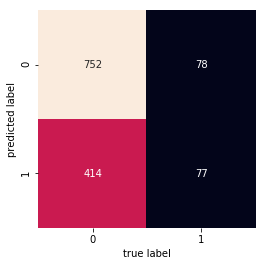

ROC Curve
AUROC Score: 0.615398660986


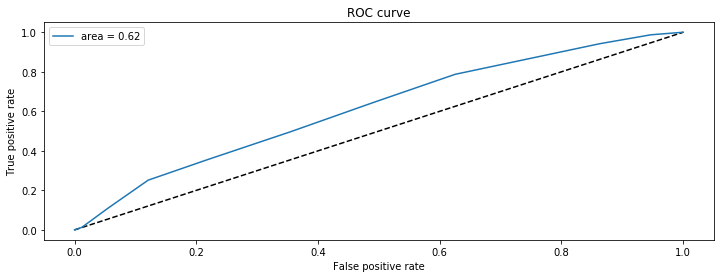

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$607.88]
Total investment cost so far is [$11485.1]
Total investment return so far is [$12092.98]
Total investment return % gain so far is [5.292770633255261%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$269.28]
Top 10 Total investment cost so far is [$1480.19]
Top 10 Total investment return so far is [$1749.47]
Top 10 Total investment return % gain so far is [18.192259101872054%]
                Company  Initial Price  Current Price  Investment Cost  \
0          Lam Research         169.92         228.65           169.92   
1     Adobe Systems Inc         190.27         220.94           190.27   
2          Red Hat Inc.         127.05         155.08           127.05   
3  Grainger (W.W.) Inc.         252.85         279.74           252.85   
4            Apple In

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Accenture plc,151.83,161.69,151.83,161.69,9.86
1,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
2,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
3,Aetna Inc,180.95,177.07,180.95,177.07,-3.88
4,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
5,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
6,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amphenol Corp,88.41,92.66,88.41,92.66,4.25


In [63]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
#X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
#print('Total available features:', len(list(X_train)))
#PCA_Component_Analysis(X_train_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
#X_train_std_scale_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale, y_train)
X_train_reduce, y_train_reduce = Down_Sample_Dataset(X_train, y_train)

#model execution with SVM
df_result = RF_Run(X_train_reduce, y_train_reduce, X_test, y_test, X_ver, calc_return=True)
df_result.to_csv('RF_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using Random Forest + Standard Scale + Down Sampling Data

Total available features: 24


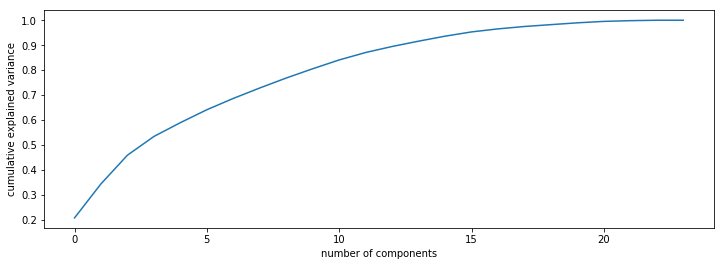

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
Random Forest Default (accuracy) Train Dataset 0.983731019523
Random Forest Default (accuracy) Test Dataset 0.629068887207

Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.65      0.91      0.75       830
          1       0.50      0.16      0.24       491

avg / total       0.59      0.63      0.56      1321

Random Forest Default Confusion Matrix:


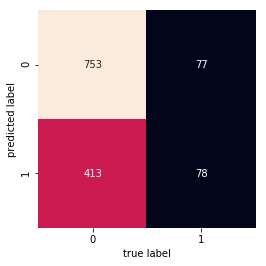

ROC Curve
AUROC Score: 0.616364189675


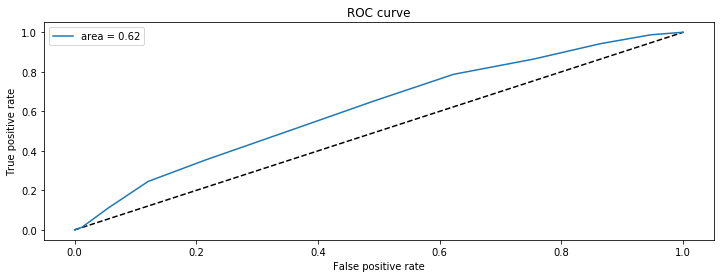

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$607.83]
Total investment cost so far is [$11496.67]
Total investment return so far is [$12104.5]
Total investment return % gain so far is [5.287009194836418%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$269.28]
Top 10 Total investment cost so far is [$1480.19]
Top 10 Total investment return so far is [$1749.47]
Top 10 Total investment return % gain so far is [18.192259101872054%]
                Company  Initial Price  Current Price  Investment Cost  \
0          Lam Research         169.92         228.65           169.92   
1     Adobe Systems Inc         190.27         220.94           190.27   
2          Red Hat Inc.         127.05         155.08           127.05   
3  Grainger (W.W.) Inc.         252.85         279.74           252.85   
4            Apple In

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Accenture plc,151.83,161.69,151.83,161.69,9.86
1,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
2,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
3,Advanced Micro Devices Inc,11.57,11.52,11.57,11.52,-0.05
4,Aetna Inc,180.95,177.07,180.95,177.07,-3.88
5,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
6,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
7,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
8,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
9,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75


In [64]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_std_scale_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale, y_train)

#model execution with SVM
df_result = RF_Run(X_train_std_scale_reduce, y_train_reduce, X_test_std_scale, y_test, X_ver_std_scale, calc_return=True)
df_result.to_csv('RF_Std_Scale_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using Random Forest + Standard Scale + PCA + Down Sampling Data

Total available features: 24


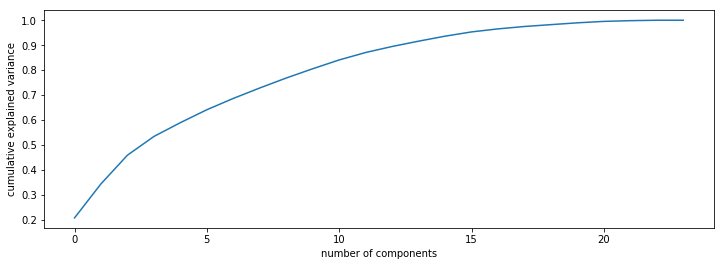

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
Random Forest Default (accuracy) Train Dataset 0.979392624729
Random Forest Default (accuracy) Test Dataset 0.647236941711

Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.67      0.90      0.77       866
          1       0.46      0.16      0.24       455

avg / total       0.60      0.65      0.59      1321

Random Forest Default Confusion Matrix:


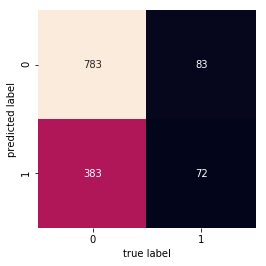

ROC Curve
AUROC Score: 0.611688706911


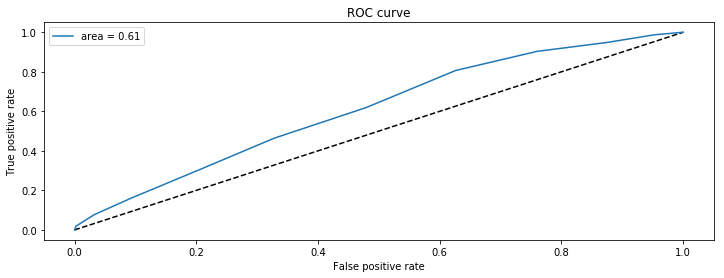

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$894.08]
Total investment cost so far is [$13622.94]
Total investment return so far is [$14517.02]
Total investment return % gain so far is [6.56304733045877%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$599.68]
Top 10 Total investment cost so far is [$4402.27]
Top 10 Total investment return so far is [$5001.95]
Top 10 Total investment return % gain so far is [13.622063162868244%]
                  Company  Initial Price  Current Price  Investment Cost  \
0         Amazon.com Inc.        1390.00        1598.39          1390.00   
1    Alphabet Inc Class C        1055.80        1164.50          1055.80   
2            Netflix Inc.         254.26         321.30           254.26   
3            Lam Research         169.92         228.65           169.92   
4       Ado

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Abbott Laboratories,58.73,63.62,58.73,63.62,4.89
1,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
2,Advanced Micro Devices Inc,11.57,11.52,11.57,11.52,-0.05
3,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
4,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
5,Alphabet Inc Class C,1055.80,1164.50,1055.80,1164.50,108.70
6,Amazon.com Inc.,1390.00,1598.39,1390.00,1598.39,208.39
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amgen Inc.,173.44,189.30,173.44,189.30,15.86


In [65]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with SVM
df_result = RF_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True)
df_result.to_csv('RF_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using GridSearch + Random Forest + Standard Scale + Down Sampling Data

Total available features: 24


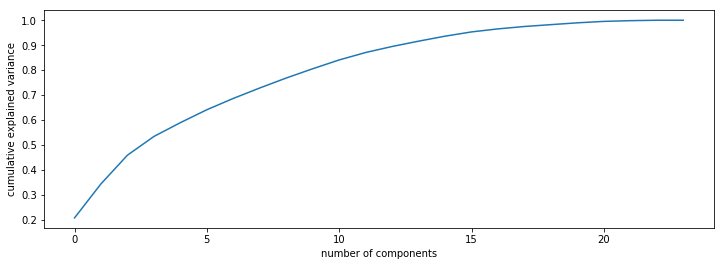

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
GridSearch Random Forest Best n_estimators: 30
GridSearch Random Forest Best max_depth: 10
GridSearch Random Forest Best min_samples_leaf: 8
GridSearch Random Forest Default (accuracy) Train Dataset 0.866594360087
GridSearch Random Forest Default (accuracy) Test Dataset 0.590461771385

GridSearch Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.59      0.92      0.72       741
          1       0.63      0.17      0.26       580

avg / total       0.60      0.59      0.52      1321

GridSearch Random Forest Default Confusion Matrix:


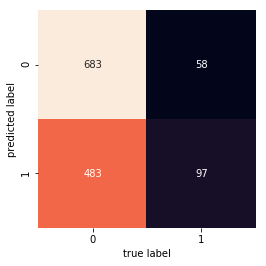

GridSearch Random Forest ROC Curve
AUROC Score: 0.654631217839


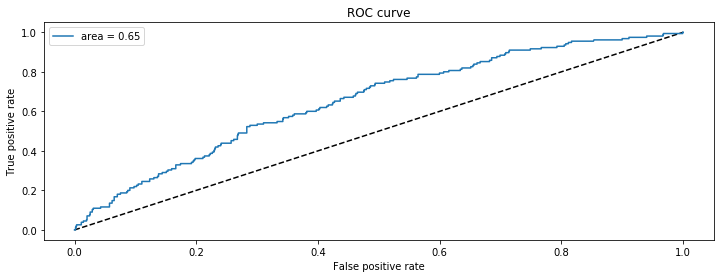

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$665.09]
Total investment cost so far is [$13942.31]
Total investment return so far is [$14607.4]
Total investment return % gain so far is [4.770299900088292%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$317.57]
Top 10 Total investment cost so far is [$1694.81]
Top 10 Total investment return so far is [$2012.38]
Top 10 Total investment return % gain so far is [18.737793616983616%]
                  Company  Initial Price  Current Price  Investment Cost  \
0            Netflix Inc.         254.26         321.30           254.26   
1            Lam Research         169.92         228.65           169.92   
2       Adobe Systems Inc         190.27         220.94           190.27   
3            Red Hat Inc.         127.05         155.08           127.05   
4    Graing

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
1,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
2,Aetna Inc,180.95,177.07,180.95,177.07,-3.88
3,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
4,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
5,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
6,Ameren Corp,53.69,53.95,53.69,53.95,0.26
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amphenol Corp,88.41,92.66,88.41,92.66,4.25


In [66]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_std_scale_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale, y_train)

#model execution with GridSearch Random Forest
df_result = GridSearch_RF_Run(X_train_std_scale_reduce, y_train_reduce, X_test_std_scale, y_test, X_ver_std_scale, calc_return=True)
df_result.to_csv('GridSearch_RF_Std_Scale_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using GridSearch + Random Forest + Standard Scale + PCA + Down Sampling Data

Total available features: 24


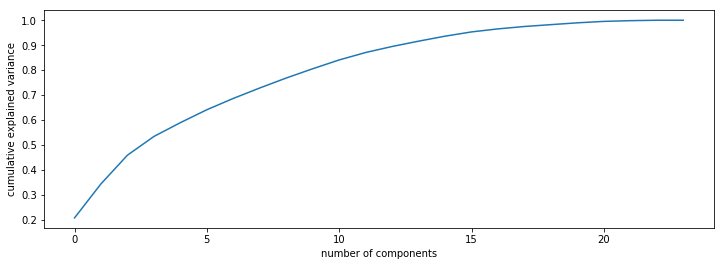

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
GridSearch Random Forest Best n_estimators: 30
GridSearch Random Forest Best max_depth: 15
GridSearch Random Forest Best min_samples_leaf: 10
GridSearch Random Forest Default (accuracy) Train Dataset 0.854663774403
GridSearch Random Forest Default (accuracy) Test Dataset 0.579863739591

GridSearch Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.57      0.92      0.71       723
          1       0.64      0.17      0.26       598

avg / total       0.60      0.58      0.51      1321

GridSearch Random Forest Default Confusion Matrix:


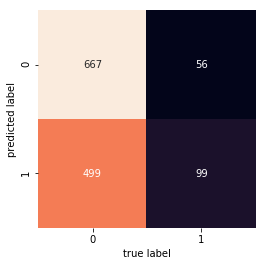

GridSearch Random Forest ROC Curve
AUROC Score: 0.643766945167


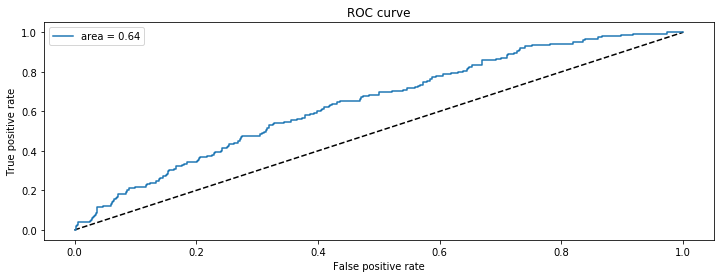

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$717.77]
Total investment cost so far is [$14400.64]
Total investment return so far is [$15118.41]
Total investment return % gain so far is [4.984292364783788%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$319.21]
Top 10 Total investment cost so far is [$2122.8]
Top 10 Total investment return so far is [$2442.01]
Top 10 Total investment return % gain so far is [15.037214999057845%]
                  Company  Initial Price  Current Price  Investment Cost  \
0            Netflix Inc.         254.26         321.30           254.26   
1            Lam Research         169.92         228.65           169.92   
2       Adobe Systems Inc         190.27         220.94           190.27   
3            Red Hat Inc.         127.05         155.08           127.05   
4    Graing

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Accenture plc,151.83,161.69,151.83,161.69,9.86
1,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
2,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
3,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
4,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
5,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
6,Ameren Corp,53.69,53.95,53.69,53.95,0.26
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amphenol Corp,88.41,92.66,88.41,92.66,4.25


In [67]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_std_scale, X_test_std_scale, X_ver_std_scale = Standard_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_std_scale)
X_train_std_scale_PCA, X_test_std_scale_PCA, X_ver_std_scale_PCA = PCA_Component_Selection(20, X_train_std_scale, X_test_std_scale, X_ver_std_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_std_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_std_scale_PCA, y_train)

#model execution with GridSearch Random Forest
df_result = GridSearch_RF_Run(X_train_std_scale_PCA_reduce, y_train_reduce, X_test_std_scale_PCA, y_test, X_ver_std_scale_PCA, calc_return=True)
df_result.to_csv('GridSearch_RF_Std_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using Random Forest + MinMax Scale + Down-Sampling Data

Total available features: 24


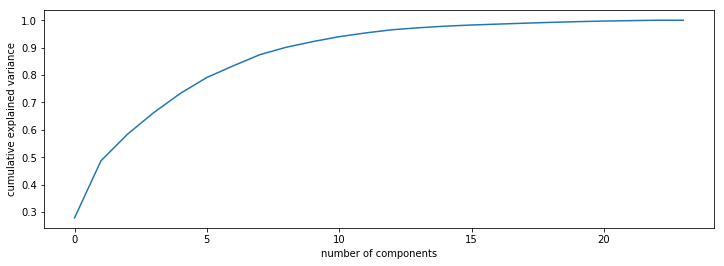

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
Random Forest Default (accuracy) Train Dataset 0.983731019523
Random Forest Default (accuracy) Test Dataset 0.635881907646

Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.65      0.91      0.76       829
          1       0.54      0.17      0.26       492

avg / total       0.61      0.64      0.57      1321

Random Forest Default Confusion Matrix:


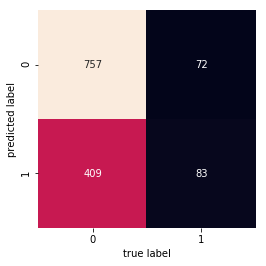

ROC Curve
AUROC Score: 0.621457422675


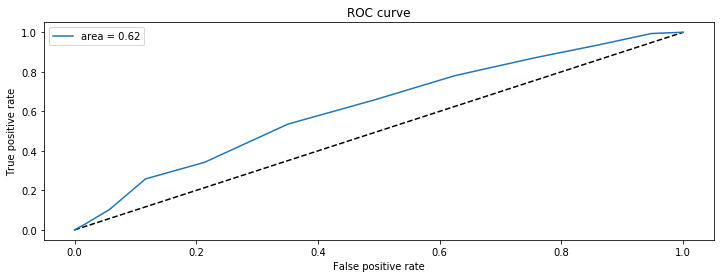

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-14] is [$659.16]
Total investment cost so far is [$11591.35]
Total investment return so far is [$12250.51]
Total investment return % gain so far is [5.686654272366894%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-14] is [$276.72]
Top 10 Total investment cost so far is [$1598.49]
Top 10 Total investment return so far is [$1875.21]
Top 10 Total investment return % gain so far is [17.311337574836255%]
                Company  Initial Price  Current Price  Investment Cost  \
0          Lam Research         169.92         228.65           169.92   
1     Adobe Systems Inc         190.27         220.94           190.27   
2          Red Hat Inc.         127.05         155.08           127.05   
3  Grainger (W.W.) Inc.         252.85         279.74           252.85   
4            Apple I

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Accenture plc,151.83,161.69,151.83,161.69,9.86
1,Activision Blizzard,67.98,76.86,67.98,76.86,8.88
2,Adobe Systems Inc,190.27,220.94,190.27,220.94,30.67
3,Aetna Inc,180.95,177.07,180.95,177.07,-3.88
4,Air Products & Chemicals Inc,156.33,170.88,156.33,170.88,14.55
5,Akamai Technologies Inc,62.81,74.97,62.81,74.97,12.16
6,Alexion Pharmaceuticals,112.72,127.08,112.72,127.08,14.36
7,American Tower Corp A,142.04,145.08,142.04,145.08,3.04
8,AmerisourceBergen Corp,91.54,100.29,91.54,100.29,8.75
9,Amphenol Corp,88.41,92.66,88.41,92.66,4.25


In [68]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_mm_scale, X_test_mm_scale, X_ver_mm_scale = MinMax_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_mm_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_mm_scale_reduce, y_train_reduce = Down_Sample_Dataset(X_train_mm_scale, y_train)

#model execution with Random Forest
df_result = RF_Run(X_train_mm_scale_reduce, y_train_reduce, X_test_mm_scale, y_test, X_ver_mm_scale, calc_return=True)
df_result.to_csv('RF_mm_Scale_Down_Sampling.csv', index=False)
df_result

### Stock Analysis using GridSearch + Random Forest + MinMax Scale + PCA + Down Sampling Data

Total available features: 24


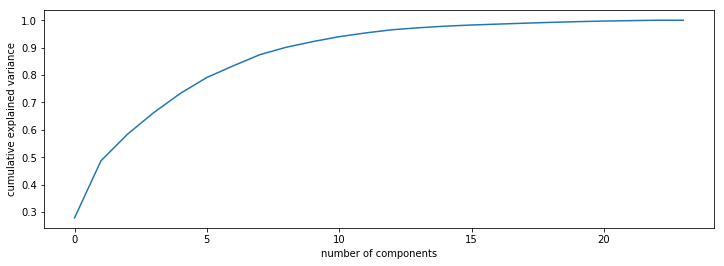

Y train: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y test: (array([0, 1], dtype=int64), array([1166,  155], dtype=int64))
Y before down-sampling: (array([0, 1], dtype=int64), array([3501,  461], dtype=int64))
Y after down-sampling: (array([0, 1], dtype=int64), array([461, 461], dtype=int64))
GridSearch Random Forest Best n_estimators: 30
GridSearch Random Forest Best max_depth: 5
GridSearch Random Forest Best min_samples_leaf: 6
GridSearch Random Forest Default (accuracy) Train Dataset 0.759219088937
GridSearch Random Forest Default (accuracy) Test Dataset 0.567751703255

GridSearch Random Forest Default Metric Report:
             precision    recall  f1-score   support

          0       0.55      0.93      0.69       691
          1       0.69      0.17      0.27       630

avg / total       0.62      0.57      0.49      1321

GridSearch Random Forest Default Confusion Matrix:


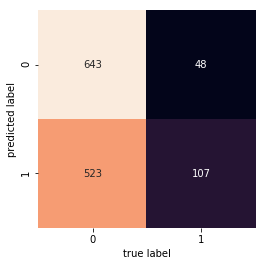

GridSearch Random Forest ROC Curve
AUROC Score: 0.665401427544


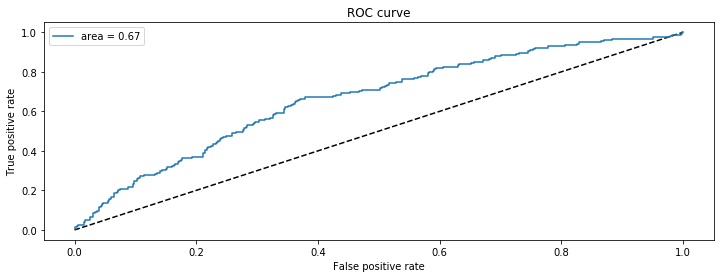

Predict using latest Key Statistic @ 2018-02-05

Recommended companies for investment and total return as below:
Total earning from [2018-02-05] till [2018-03-15] is [$90.65]
Total investment cost so far is [$3522.52]
Total investment return so far is [$3435.32]
Total investment return % gain so far is [2.5734417405720906%]

Top 10 companies by investment profit:
Top 10 Total earning from [2018-02-05] till [2018-03-15] is [$127.93]
Top 10 Total investment cost so far is [$1060.52]
Top 10 Total investment return so far is [$1188.45]
Top 10 Total investment return % gain so far is [12.062950250820352%]
                          Company  Initial Price  Current Price  \
0               Adobe Systems Inc         190.27         219.76   
1              Cintas Corporation         156.46         176.13   
2    Air Products & Chemicals Inc         156.33         170.93   
3  Cognizant Technology Solutions          73.11          83.79   
4         Akamai Technologies Inc          62.81         

,Company,Initial Price,Current Price,Investment Cost,Investment Return,Profit/Loss
0,Activision Blizzard,67.98,75.93,67.98,75.93,7.95
1,Adobe Systems Inc,190.27,219.76,190.27,219.76,29.49
2,Air Products & Chemicals Inc,156.33,170.93,156.33,170.93,14.60
3,Akamai Technologies Inc,62.81,73.30,62.81,73.30,10.49
4,Alexion Pharmaceuticals,112.72,121.08,112.72,121.08,8.36
5,American Express Co,92.01,95.37,92.01,95.37,3.36
6,American Tower Corp A,142.04,146.25,142.04,146.25,4.21
7,AmerisourceBergen Corp,91.54,100.60,91.54,100.60,9.06
8,Amphenol Corp,88.41,92.51,88.41,92.51,4.10
9,"Analog Devices, Inc.",84.96,94.66,84.96,94.66,9.70


In [78]:
#analysis target
how_much_better = 20
invest_unit_per_stock = 1

#Historical & Forward null value handling
#ranking=0 - for comparing stock price changes against S&P 500 price changes
#ranking=1 - for comparing stock price changes against its previous price changes
X,y = Historical_Data_Preprocessing_All_Industry(df_historical, ranking=0)
X_ver,z = Forward_Data_Preprocessing_All_Industry(df_forward)

#split historical data into Train & Test set
X_train, X_test, y_train, y_test = Train_Test_Split(X, y)

#Feature Scaling and Normalization for Train, Test & Verification dataset
X_train_mm_scale, X_test_mm_scale, X_ver_mm_scale = MinMax_Scale(X_train, X_test, X_ver)

#check if there's any need for PCA to reduce number of features
print('Total available features:', len(list(X_train)))
PCA_Component_Analysis(X_train_mm_scale)
X_train_mm_scale_PCA, X_test_mm_scale_PCA, X_ver_mm_scale_PCA = PCA_Component_Selection(20, X_train_mm_scale, X_test_mm_scale, X_ver_mm_scale)

#check if there's imbalance dataset?
print('Y train:',np.unique(y_train,return_counts=True))
print('Y test:',np.unique(y_test,return_counts=True))

#handling imbalance dataset by down-sampling the train set data
X_train_mm_scale_PCA_reduce, y_train_reduce = Down_Sample_Dataset(X_train_mm_scale_PCA, y_train)

#model execution with GridSearch Random Forest
df_result = GridSearch_RF_Run(X_train_mm_scale_PCA_reduce, y_train_reduce, X_test_mm_scale_PCA, y_test, X_ver_mm_scale_PCA, calc_return=True)
df_result.to_csv('GridSearch_RF_mm_Scale_PCA_Down_Sampling.csv', index=False)
df_result

### Conclusion

With Random Forest, the best estimated model is using the combination of:

"Stock Analysis using GridSearch + Random Forest + MinMax Scale + PCA + Down Sampling Data"

with 

- GridSearch Random Forest Best n_estimators: 30
- GridSearch Random Forest Best max_depth: 5
- GridSearch Random Forest Best min_samples_leaf: 6
- GridSearch Random Forest Default (accuracy) Train Dataset 0.759219088937
- GridSearch Random Forest Default (accuracy) Test Dataset 0.567751703255

- GridSearch Random Forest Default Metric Report:
                     precision    recall  f1-score   support

                  0       0.55      0.93      0.69       691
                  1       0.69      0.17      0.27       630

         avg / total      0.62      0.57      0.49      1321

- AUROC Score: 0.665401427544
- Top 10 investments total return % gain from [2018-02-05] till [2018-03-13] is 15.15%

| Company         |
|---------------  |
| `Lam Research`	  |
| `Adobe Systems Inc` |
| `Red Hat Inc.`        |
| `Grainger (W.W.) Inc.`   |
| `Western Digital`   |
| `Intuit Inc.`   |
| `KLA-Tencor Corp.`   |
| `Cintas Corporation`   |
| `Fiserv Inc`   |
| `Roper Technologies`   |
